<a href="https://colab.research.google.com/github/1900690/yolov10/blob/main/syakuyaku-train-yolov10-object-detection-on-custom-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# カスタムデータセットでYOLOv10の物体検出をトレーニングする方法

---

[![arXiv](https://img.shields.io/badge/arXiv-2405.14458-b31b1b.svg)](https://arxiv.org/pdf/2405.14458.pdf)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/THU-MIG/yolov10)
[![Hugging Face Spaces](https://img.shields.io/badge/%F0%9F%A4%97%20Hugging%20Face-Spaces-blue)](https://huggingface.co/spaces/SkalskiP/YOLO-ARENA)

YOLOv10は、リアルタイムでエンドツーエンドの物体検出を行うYOLOシリーズの新世代です。非最大抑制（NMS）の必要性をなくし、モデル・アーキテクチャを包括的に最適化することで、YOLOの性能と効率の両方を向上させることを目的としています。この進歩により、計算オーバーヘッドが削減され、効率と能力の両方が向上します。YOLOv10は最先端の性能と効率を示し、YOLOv10-SはRT-DETR-R18より1.8倍高速で、パラメータとFLOP数が大幅に少ない。さらに、YOLOv10-Bは、同じ性能を維持しながら、YOLOv9-Cと比較してレイテンシを46%削減し、パラメータを25%削減しています。

<p align="center">
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_latency.svg" width=48%>
  <img src="https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov10_params.svg" width=48%> <br>
  Comparisons with others in terms of latency-accuracy (left) and size-accuracy (right) trade-offs.
</p>

## Pro Tip: GPUアクセラレーションを使う

Google Colabでこのノートブックを実行している場合、`Edit` -> `Notebook settings` -> `Hardware accelerator` に移動し、`GPU`に設定し、`Save`をクリックします。これでノートブックがGPUを使用するようになり、モデルのトレーニング時間が大幅に短縮されます。

## このチュートリアルのステップ

このチュートリアルでは、以下を取り上げます：

- 始める前に
- YOLOv10をインストールする
- 訓練済み重みのダウンロード
- サンプルデータのダウンロード
- 学習済みCOCOモデルによる推論
- Roboflow Universeからデータセットをダウンロードする
- カスタムトレーニング
- カスタムモデルの検証
- カスタムモデルによる推論

In [1]:
#ドライブマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#ファイルコピー
import shutil
shutil.copyfile( "/content/drive/MyDrive/datasets.zip","/content/datasets.zip")
shutil.unpack_archive('/content/datasets.zip', '/content/datasets')

## 始める前に

GPUにアクセスできることを確認しよう。nvidia-smi`コマンドを使うことができる。問題があれば、`ランタイム` -> `ランタイムのタイプを変更` に移動し、`GPU`に設定し、`保存`をクリックする。

In [4]:
#GPUに接続しているか確認
!nvidia-smi

Sun Jun 16 23:45:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
#カレントディレクトリの確認とインストール場所の設定
import os
HOME = os.getcwd()
print(HOME)

/content


## YOLOv10をインストールする

**注意：**現在、YOLOv10は独自のPyPIパッケージを持っていない。そのため、ソースからインストールする必要がある。

In [6]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.2 MB/s eta 0:00:00


**注:** 2つの追加パッケージもインストールする： [Roboflowユニバース](https://universe.roboflow.com/)からデータセットをダウンロードするための[`roboflow`](https://github.com/roboflow/roboflow-python)と、結果を可視化するための[`supervision`](https://github.com/roboflow/supervision)です。

In [7]:
!pip install -q supervision roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.0/124.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.4 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76


## 訓練済み重みのダウンロード

**注:** YOLOv10は、COCOデータセットで事前にトレーニングされたウェイトファイルを様々なサイズで提供しています。ダウンロードしてみよう。

In [15]:
!mkdir -p {HOME}/weights
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 222M
-rw-r--r-- 1 root root 100M May 26 15:53 yolov10l.pt
-rw-r--r-- 1 root root 123M May 26 15:54 yolov10x.pt


In [ ]:
#@title 2.学習画像をアップロード
#@markdown   ”①AI学習用データ作成について”作成した画像をアップロード

#ライブラリをインポート(機能を使えるようにする)
import shutil
import os
from google.colab import files
import math

#スイッチ
グーグルドライブからアップロード=False#@param {type:"boolean"}
drive=グーグルドライブからアップロード
ローカルからアップロード=True#@param {type:"boolean"}
direct=ローカルからアップロード

#すでにフォルダがある場合は消す
if os.path.exists("/content/datasets"):
  shutil.rmtree("/content/datasets")
if os.path.exists("/content/datasets.zip"):
  os.remove("/content/datasets.zip")

if direct==True:
  #データをアップロード
  uploaded = files.upload()
  #データを解凍
  shutil.unpack_archive('/content/datasets.zip', '/content/datasets')
if drive==True:
  #グーグルドライブに接続
  drive.mount('/content/drive')
  #グーグルドライブからcontentにコピー
  shutil.copyfile("/content/drive/MyDrive/datasets.zip","/content/datasets.zip")
  #データを解凍
  shutil.unpack_archive('/content/datasets.zip', '/content/datasets')

In [ ]:
#@title ★画像を学習用とテスト用に分割★
#ライブラリをインポート
import shutil
import os
from sklearn.model_selection import train_test_split
import math

shutil.unpack_archive('/content/datasets.zip')

title='syakuyaku'

#分割元のパスを作成
originals='/content/original'
annotations='/content/yolo/annotations'

#分割先のパスを作成
train_images = '/content/datasets/'+title+'/train/images'
train_labels = '/content/datasets/'+title+'/train/labels'
valid_images = '/content/datasets/'+title+'/valid/images'
valid_labels = '/content/datasets/'+title+'/valid/labels'

#分割先のファイルを作成
if os.path.exists('/content/datasets/'+title):
  shutil.rmtree('/content/datasets/'+title)
if not os.path.exists('/content/datasets/'+title):
  os.makedirs(train_images)
  os.makedirs(train_labels)
  os.makedirs(valid_images)
  os.makedirs(valid_labels)


#フォルダの中のファイルのリストを作成
read_files_annotations = os.listdir(annotations)
read_files_annotations.sort()
read_files_originals= os.listdir(originals)
read_files_originals.sort()

#@markdown何％をテスト用に分割するのかを定義
分割割合=0.2#@param {type:"slider", min:0, max:1, step:0.1}

#分割割合に合わせてファイルのリストを分割
annotations_train, annotations_test, originals_train, originals_test = train_test_split(read_files_annotations,read_files_originals,test_size=分割割合)


#画像とアノテーションを分ける
for filename in annotations_train:
  shutil.copy( annotations+"/"+filename,train_labels)
for filename in annotations_test:
  shutil.copy( annotations+"/"+filename,valid_labels)
for filename in originals_train:
  shutil.copy( originals+"/"+filename,train_images)
for filename in originals_test:
  shutil.copy( originals+"/"+filename,valid_images)

#最大公約数を計算
greatest_common_divisor=math.gcd(sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)),sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))

#分割されたファイル数を表示
print("train/imagesは",sum(os.path.isfile(os.path.join(train_images, name)) for name in os.listdir(train_images)))
print("train/labelsは",sum(os.path.isfile(os.path.join(train_labels, name)) for name in os.listdir(train_labels)))
print("valid/imagesは",sum(os.path.isfile(os.path.join(valid_images, name)) for name in os.listdir(valid_images)))
print("valid/labelsは",sum(os.path.isfile(os.path.join(valid_labels, name)) for name in os.listdir(valid_labels)))
print("最大公約数は",greatest_common_divisor)

train/imagesは 44
train/labelsは 44
valid/imagesは 11
valid/labelsは 11
最大公約数は 11


In [10]:
#@markdown *  パスなどを記載したファイルを作成
%%writefile /content/datasets/syakuyaku/data.yaml
names:
- 0
- 1
- 2
- 3

nc: 4

test: ../test/images
train: ../train/images
val: ../valid/images

Writing /content/datasets/syakuyaku/data.yaml


## カスタムトレーニング

In [18]:
%cd {HOME}

!yolo task=detect mode=train epochs=100 batch=3 plots=True imgsz=1280\
model={HOME}/weights/yolov10l.pt \
data=/content/datasets/syakuyaku/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.34 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10l.pt, data=/content/datasets/syakuyaku/data.yaml, epochs=100, time=None, patience=100, batch=3, imgsz=1280, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=Non

In [ ]:
#変更前
#%cd {HOME}
#!yolo task=detect mode=train epochs=10 batch=32 plots=True\
#model={HOME}/weights/yolov10n.pt \
#data={dataset.location}/data.yaml

In [19]:
#学習後のフォルダに何があるか確認
!ls {HOME}/runs/detect/train6/

args.yaml					     PR_curve.png	  train_batch1.jpg
confusion_matrix_normalized.png			     R_curve.png	  train_batch2.jpg
confusion_matrix.png				     results.csv	  val_batch0_labels.jpg
events.out.tfevents.1718584997.f6113c1684f0.17822.0  results.png	  val_batch0_pred.jpg
F1_curve.png					     train_batch0.jpg	  val_batch1_labels.jpg
labels_correlogram.jpg				     train_batch1350.jpg  val_batch1_pred.jpg
labels.jpg					     train_batch1351.jpg  weights
P_curve.png					     train_batch1352.jpg


/content


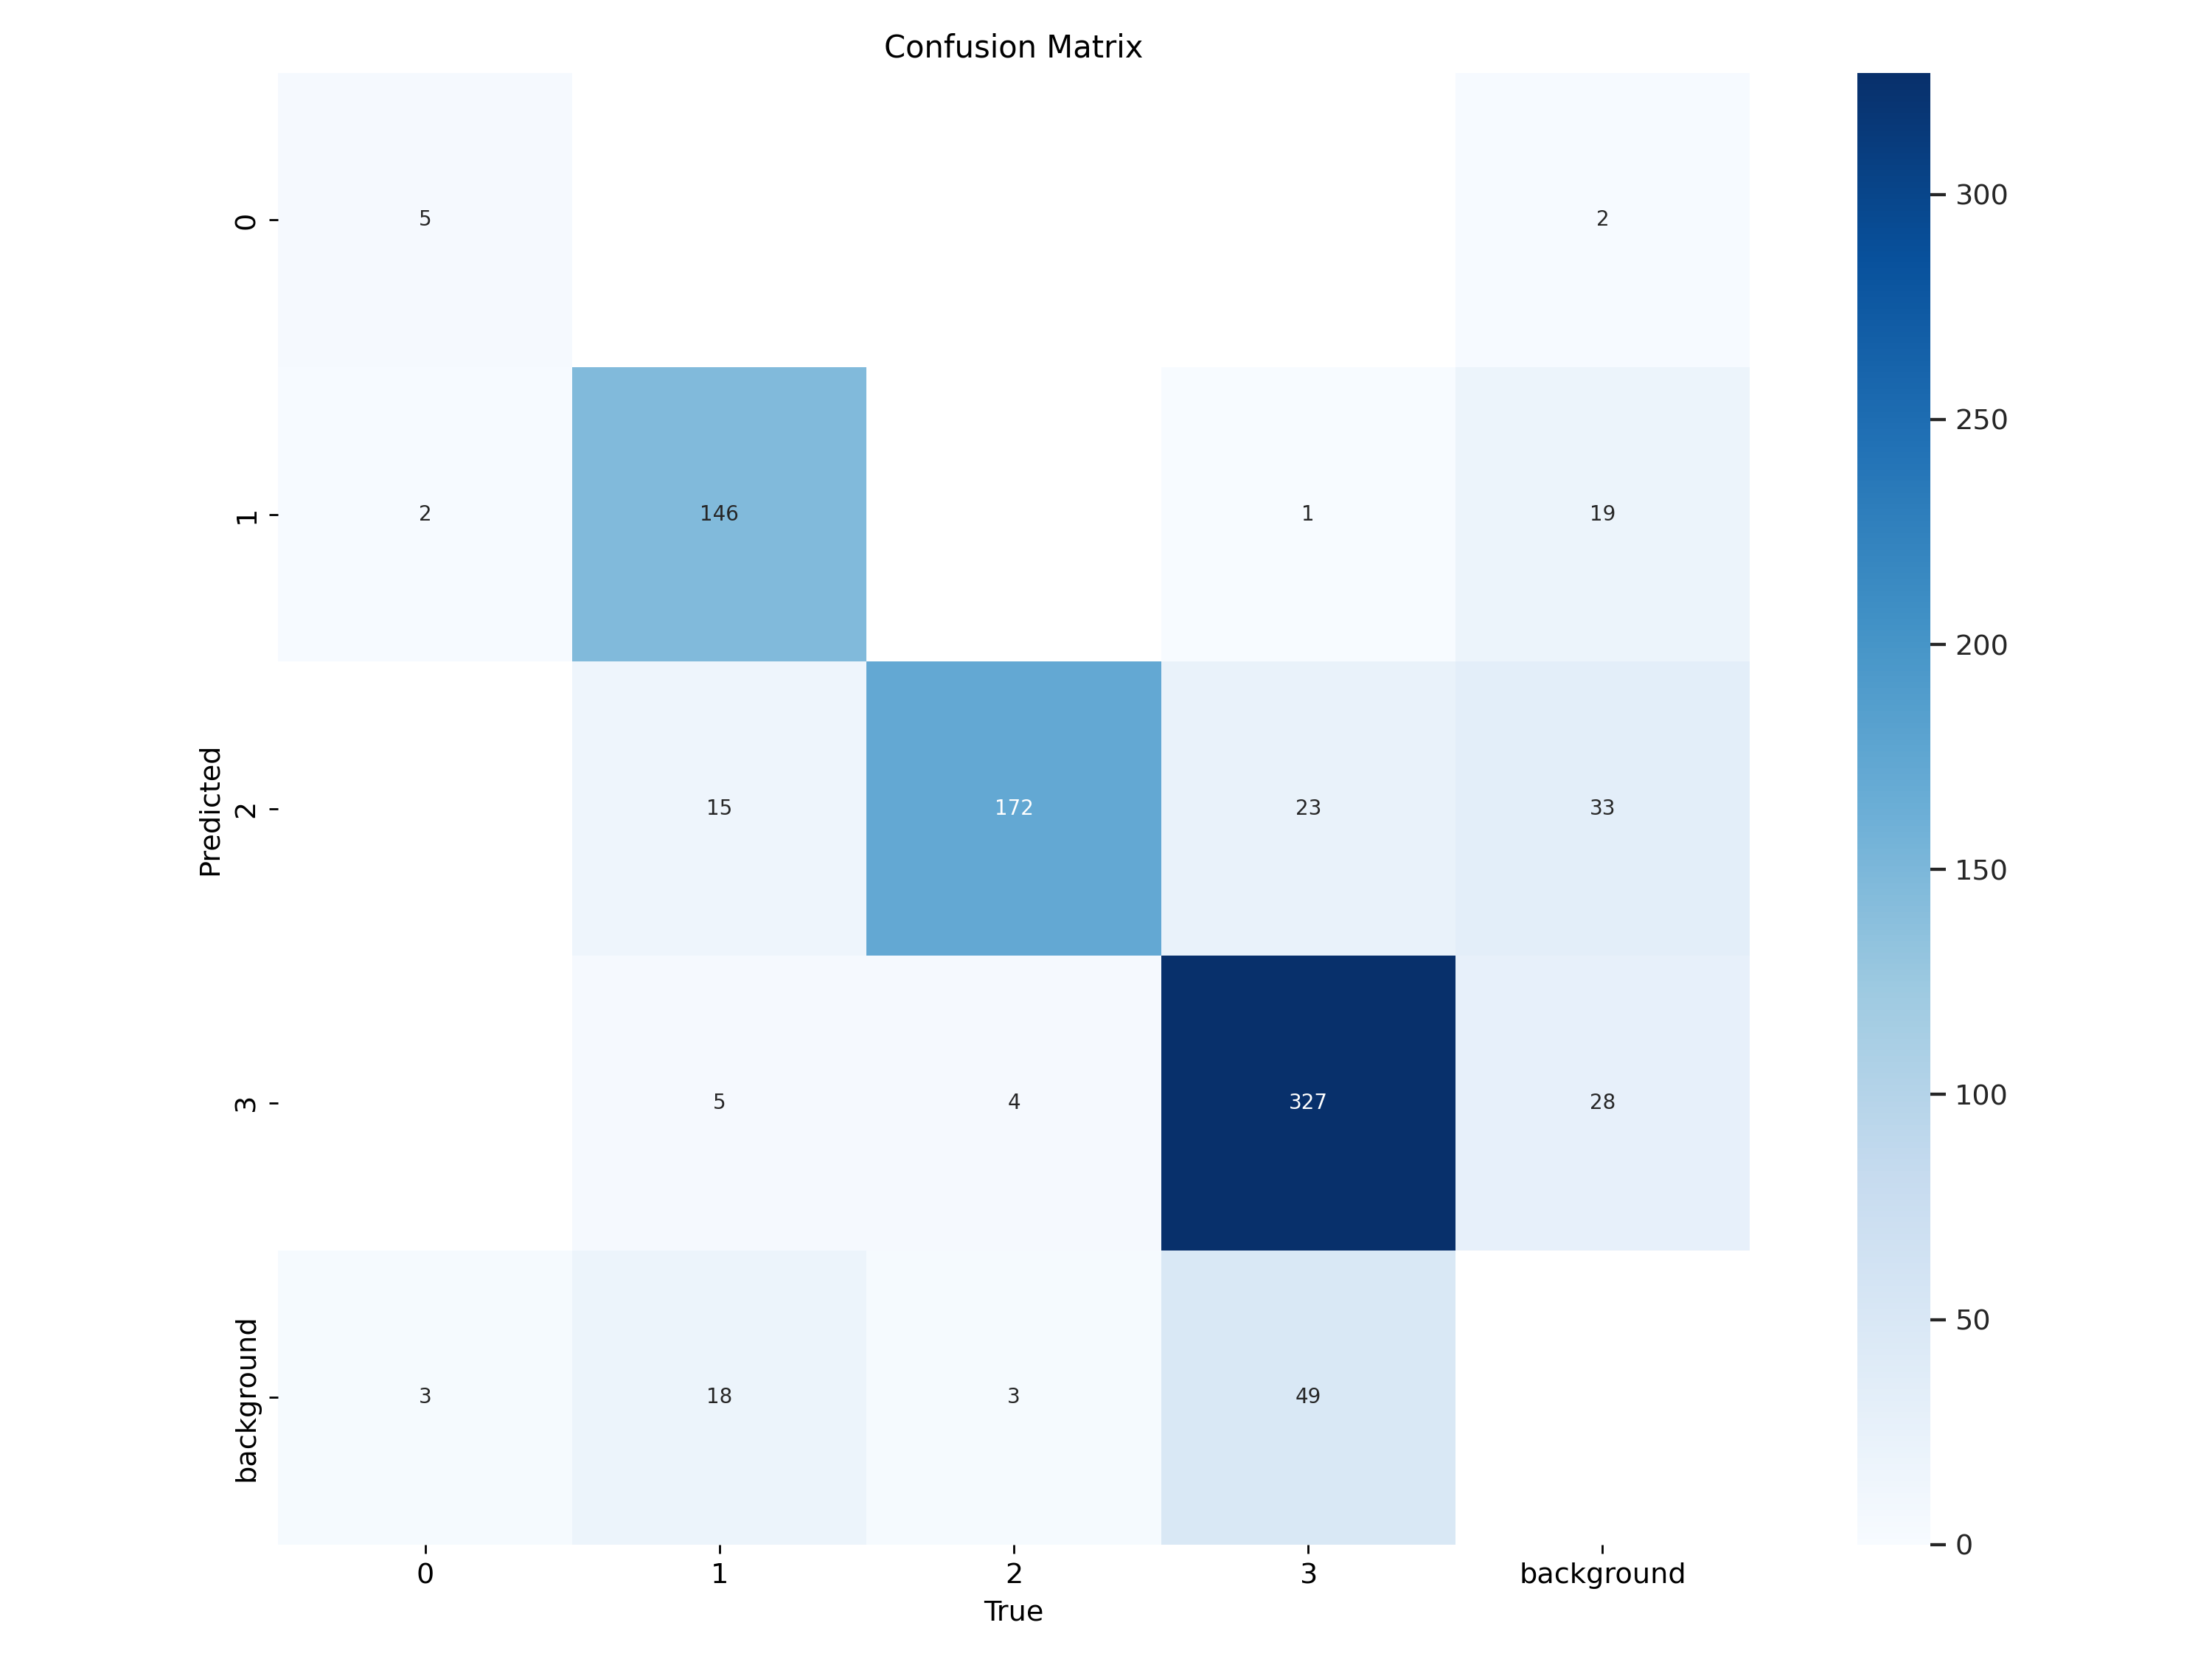

In [20]:
#confusionマトリックスを表示
%cd {HOME}
from IPython.display import Image
Image(filename=f'{HOME}/runs/detect/train6/confusion_matrix.png', width=600)

/content


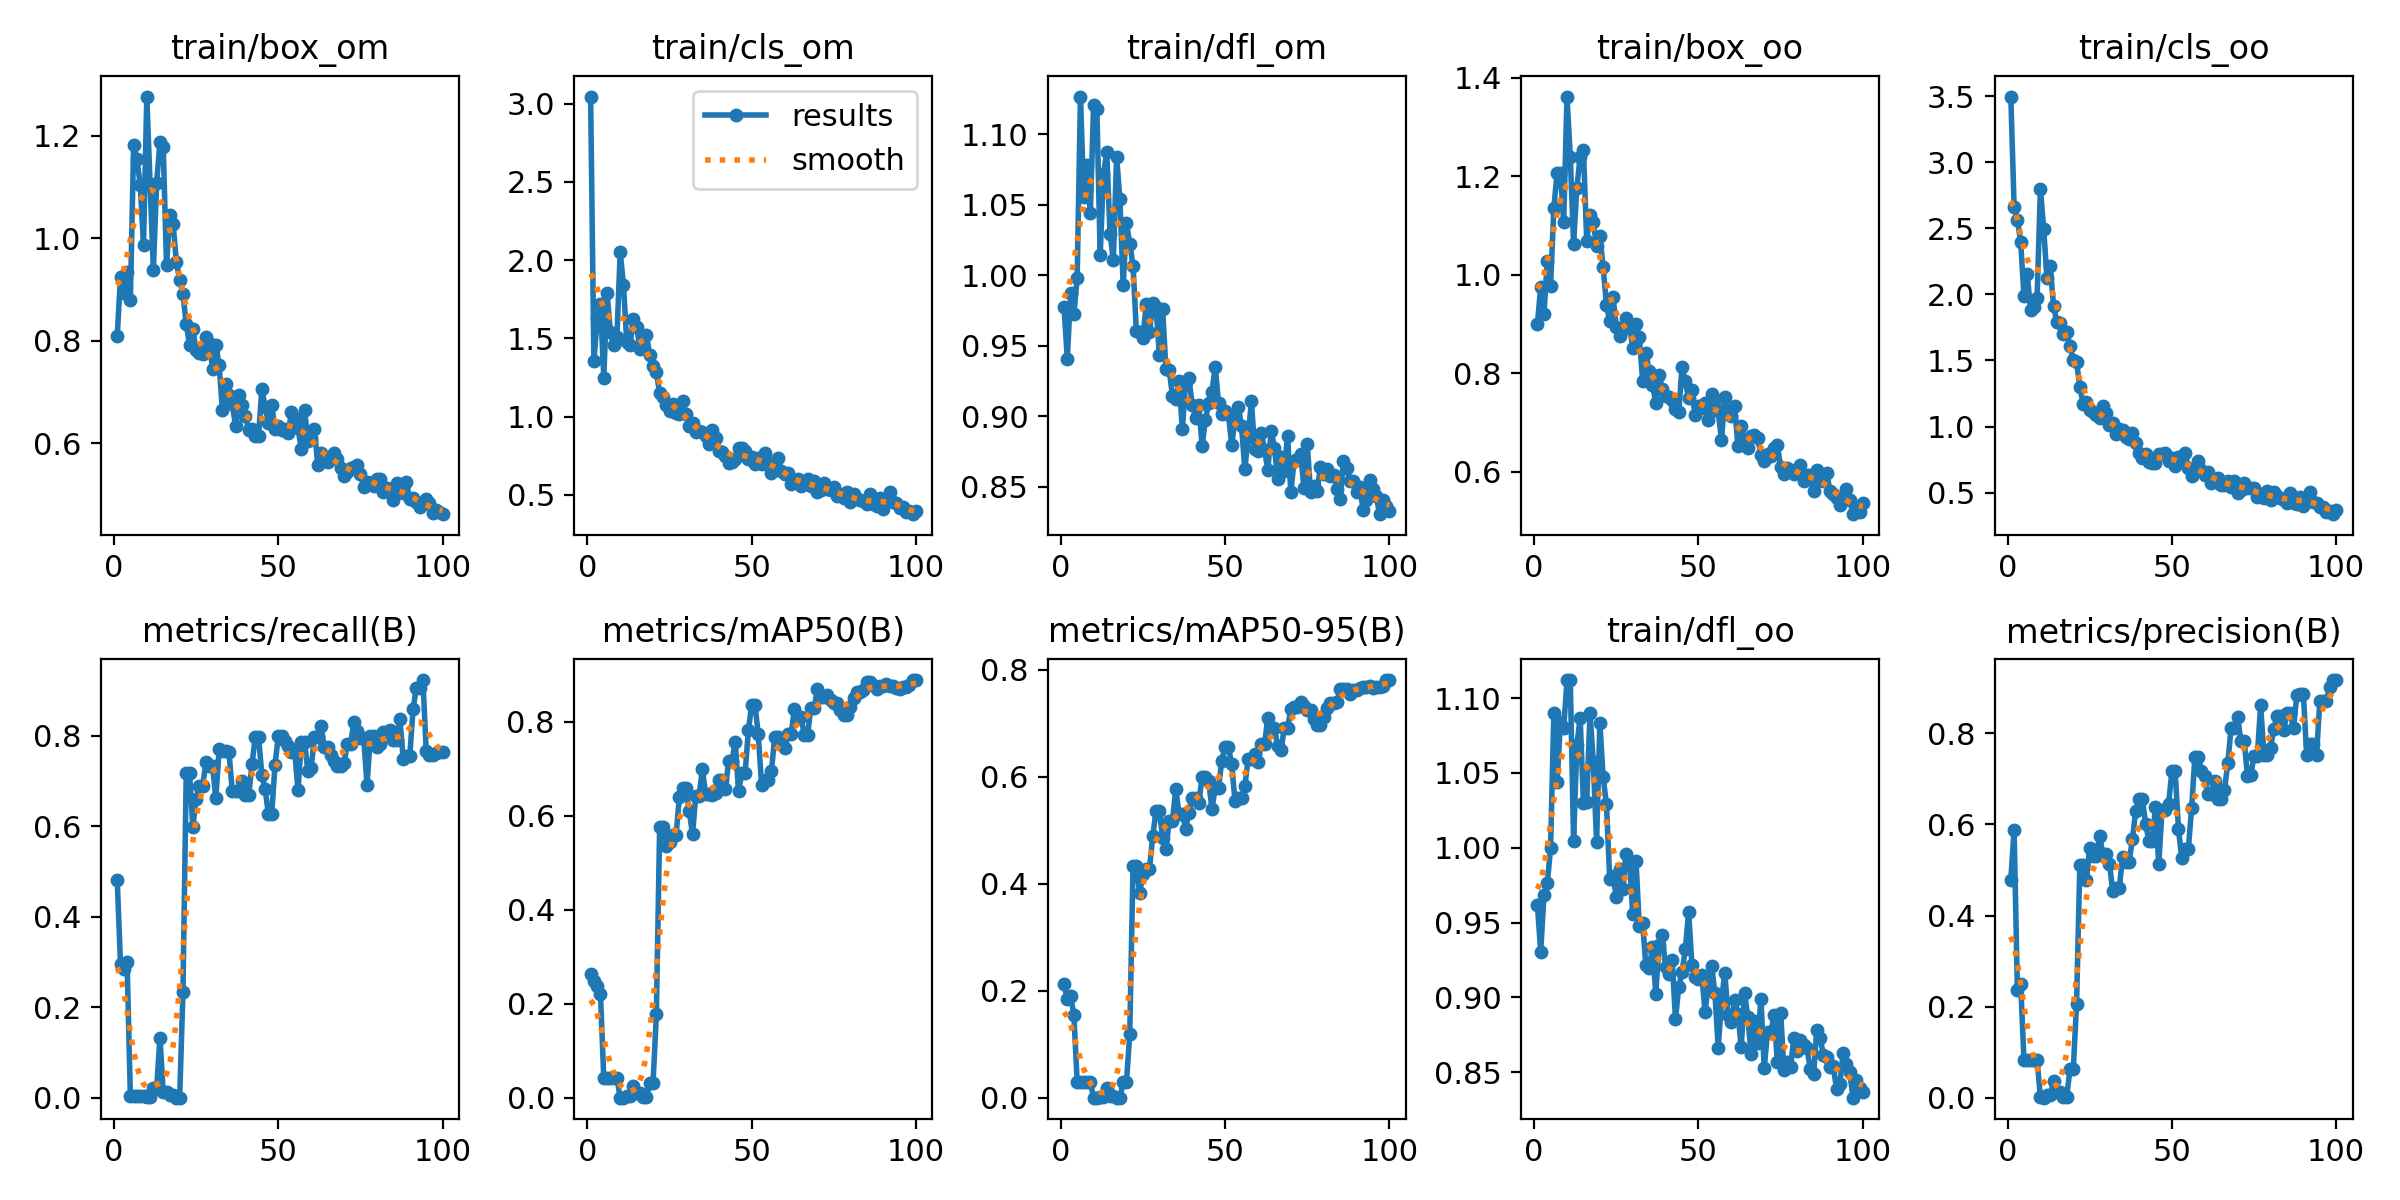

In [21]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train6/results.png', width=600)

## カスタムモデルによる推論

**注:**新しく学習したモデルをロードすることから始めましょう。

In [22]:
from ultralytics import YOLOv10
import supervision as sv

model = YOLOv10(f'{HOME}/runs/detect/train6/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"/content/datasets/syakuyaku/valid/images",
    annotations_directory_path=f"/content/datasets/syakuyaku/valid/labels",
    data_yaml_path=f"/content/datasets/syakuyaku/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

**注：**検証セットからランダムに画像を選択し、結果を視覚化してみましょう。


0: 736x1280 4 1s, 30 2s, 44 3s, 121.9ms
Speed: 9.6ms preprocess, 121.9ms inference, 155.3ms postprocess per image at shape (1, 3, 736, 1280)


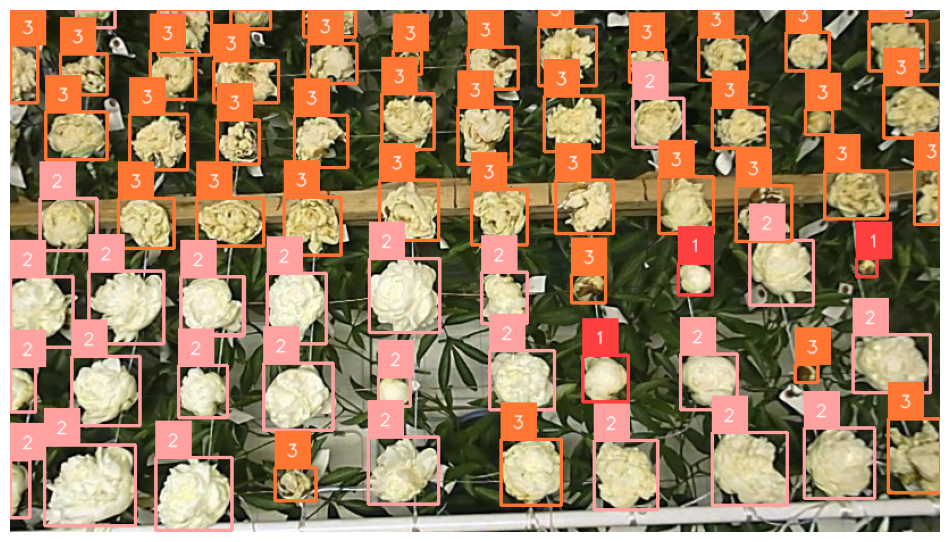

In [23]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [27]:
#@title 動画で検証

#作業ディレクトリを移動
%cd {HOME}

!yolo task=detect \
      mode=predict \
      model=/content/runs/detect/train6/weights/best.pt \
      conf=0.4 \
      imgsz=1280\
      show_conf=False \
      save_txt=False \
      device=0\
      source="/content/drive/MyDrive/mp4_out/out_TLC00009.mp4"

/content
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv10l summary (fused): 461 layers, 25722536 parameters, 0 gradients, 126.3 GFLOPs

video 1/1 (frame 1/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 9 0s, 20 1s, 112.9ms
video 1/1 (frame 2/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 7 0s, 25 1s, 1 2, 75.4ms
video 1/1 (frame 3/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 7 0s, 25 1s, 3 2s, 79.3ms
video 1/1 (frame 4/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 6 0s, 26 1s, 2 2s, 78.7ms
video 1/1 (frame 5/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 6 0s, 27 1s, 2 2s, 78.7ms
video 1/1 (frame 6/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 9 0s, 25 1s, 2 2s, 78.7ms
video 1/1 (frame 7/526) /content/drive/MyDrive/mp4_out/out_TLC00009.mp4: 736x1280 6 0s, 23 1s, 7 2s, 77.8ms
video 1/1 (frame 8/526) /content/drive/MyDrive/mp4_out/out_TLC00009.

In [ ]:
#@title 学習に必要なものを圧縮して保存
#ライブラリをインポート
import shutil
import os
from google.colab import files

#スイッチ
ファイルをグーグルドライブに保存=False#@param {type:"boolean"}
drive=ファイルをグーグルドライブに保存
ファイルをダウンロードする=True#@param {type:"boolean"}
direct=ファイルをダウンロードする

#圧縮
shutil.make_archive('/content/datasets', format='zip', root_dir='/content/dataset')
if drive==True:
  #グーグルドライブに接続
  from google.colab import drive
  drive.mount('/content/drive')
  #グーグルドライブにコピー
  shutil.copyfile("/content/datasets.zip","/content/drive/MyDrive/datasets.zip")

if direct==True:
  files.download("/content/datasets.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>